In [201]:
from tqdm import tqdm_notebook
import glob
import os
import seaborn as sb
import numpy as np
import xarray as xr
import matplotlib.pyplot as pl
import matplotlib.ticker as mtick
from matplotlib import rcParams
from matplotlib import rc
from IPython.core.display import display, HTML

In [2]:
%matplotlib inline
display(HTML("<style>.container {width:90% !important;}</style>"))

In [162]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
sb.set_style('dark')
fontSize=16
rcParams['xtick.labelsize']=fontSize
rcParams['ytick.labelsize']=fontSize
rcParams['xtick.minor.visible'] = False
rcParams['xtick.major.top'] = True
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['xtick.direction'] = 'out'
rcParams['axes.formatter.limits'] = (-2,2)

In [240]:
def SubSample(path,latSlice=2, lonSlice=5):
    """slice the dataset for faster rendering"""
    with xr.open_dataset(path) as rawEnsemble:
        subSample = rawEnsemble.data_vars['rrs_unc'][:, ::latSlice, ::lonSlice].copy()
        dsSubSample = subSample.to_dataset()
    return dsSubSample

def GetData(band, latSlice=1, lonSlice=1):
    ds = SubSample(fileDict[band], latSlice=1, lonSlice=1)
    arrLt = ds.sel(experiment=['Lt']).to_array(dim='temp').squeeze(['temp','experiment'])
    arrAll = ds.sel(experiment=['All']).to_array(dim='temp').squeeze(['temp','experiment'])
    commonMask = np.logical_or(np.isnan(arrLt), np.isnan(arrAll))
    maLt = np.ma.array(arrLt, mask=commonMask)
    maAll = np.ma.array(arrAll, mask=commonMask)
    assert maAll.compressed().shape == maLt.compressed().shape
    return maAll, maLt

def ProcessAndPlot(bands, cols=2, rows=3, **kwopts):
    """
    kwopts: 
        saveName
        figsize
    """
    rngDict={'412': (6e-5, 1.3e-3), '443': (5e-5, 1.1e-3),
            '490': (4e-5, 1.1e-3), '510': (3e-5, 1.1e-3),
            '555': (3e-5, 1.1e-3), '670': (1e-5, 3e-4)}
    binDict={'412': 50, '443': 50, '490': 50,
            '510': 50, '555': 50, '670': 40}
    fsize = kwopts.pop('figsize', (16,20))
    sname = kwopts.pop('saveName', None)
    f, ax = pl.subplots(ncols=cols, nrows=rows, figsize=fsize)
    for ai, band in tqdm_notebook(zip(ax.ravel(), bands), total=len(bands)):
        maAll, maLt = GetData(band)
        rng = rngDict[band]
        binNums = binDict[band]
        logbins = np.logspace(np.log10(rng[0]), np.log10(rng[1]), binNums)
        medAll = np.ma.median(maAll)
        medLt = np.ma.median(maLt)
        minorLocator = mtick.LogLocator(subs=np.arange(1,11)/10)
        ai.set_title('$\lambda=%s nm$' % band, fontsize=18)
        ai.hist(maLt.compressed(), bins=logbins, histtype='stepfilled',
                range=rng, label='Lt', normed=True, alpha=0.8, zorder=2)
        ai.hist(maLt.compressed(), bins=logbins, range=rng, normed=True,
               histtype='step', linewidth=2, color='m', zorder=1)
        ai.axvline(x=medLt, linewidth=3, linestyle='--', alpha=0.7,
                   color='m', zorder=0, label='Lt median: %.1e' % medLt)
        ai.hist(maAll.compressed(), bins=logbins, color='gray', normed=True,
                histtype='stepfilled', alpha=0.7, range=rng, label='Lt + anc.',
               zorder=4);
        ai.hist(maAll.compressed(), bins=logbins, range=rng, normed=True,
               histtype='step', linewidth=2, color='k', zorder=5)
        ai.axvline(x=medAll, linewidth=3, linestyle='--', alpha=0.7, color='k',
                  zorder=3, label = 'Lt + anc median: %.1e' % medAll)
        leg = ai.legend(fontsize=fontSize)
        leg.set_title('Perturbation source:', prop = {'size':fontSize})
        ai.set_xlim(rng)
        ai.set_xscale('log')
        ai.xaxis.set_minor_locator(minorLocator)
        ai.xaxis.set_ticks_position('bottom')
        ai.xaxis.grid(True, which='minor')
        ai.xaxis.set_minor_formatter(mtick.NullFormatter()) # removes duplicate minor labels
        if int(band)> 510:
            ai.set_xlabel('$Rrs \\ (sr^{-1})$', fontsize=16)
        if band in ['412', '490','555']:
            ai.set_ylabel('$freq.$', fontsize=16)
    if sname:
        fmt = sname.split('.')[-1]
        if not fmt:
            fmt = 'png'
        f.savefig(sname, dpi=300, format=fmt)
        return None
    else:
        return f, ax

In [196]:
dataDir = '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/'
origName = 'S20031932003200.L3m_*.nc'
fGen = glob.iglob(os.path.join(dataDir,origName))
fileDict={file.rsplit('_')[1]: file for file in fGen}
bands = list(fileDict.keys())
bands.sort()
# Display files
fileDict

{'412': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003200.L3m_412_8D.nc',
 '443': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003200.L3m_443_8D.nc',
 '490': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003200.L3m_490_8D.nc',
 '510': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003200.L3m_510_8D.nc',
 '555': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003200.L3m_555_8D.nc',
 '670': '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/DATA/AncillaryMC/Synthesis/S20031932003200.L3m_670_8D.nc'}

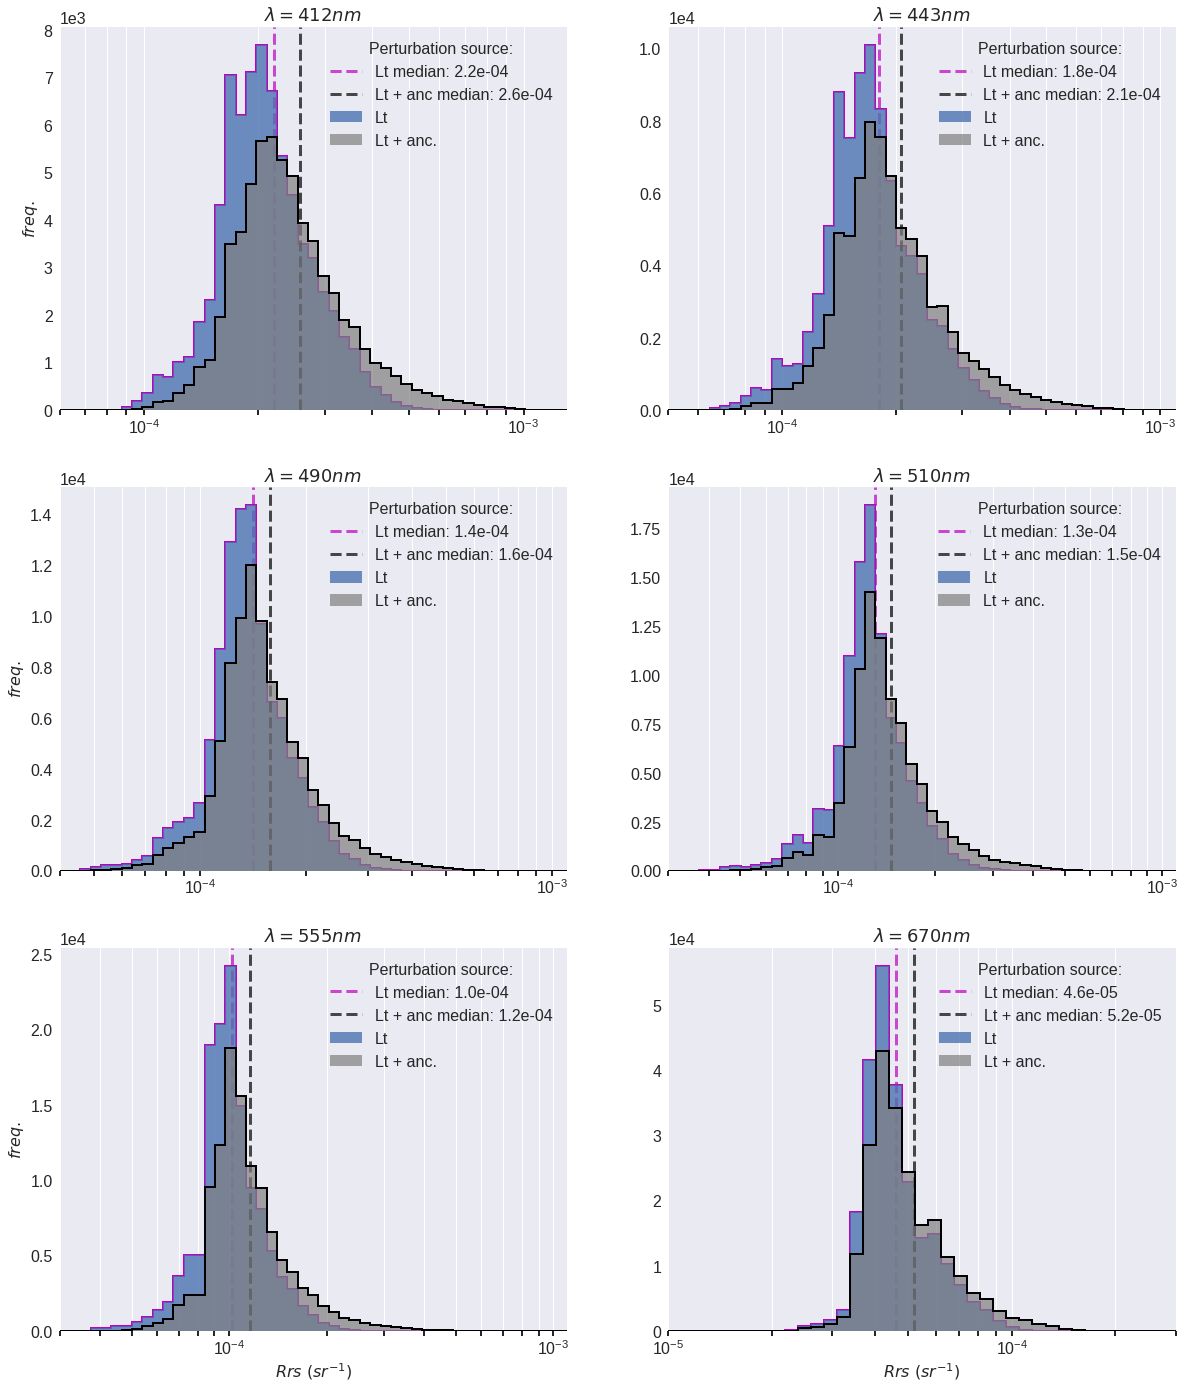

In [241]:
ProcessAndPlot(bands, saveName='/accounts/ekarakoy/Desktop/LtvsLtAnc.png', figsize=(20, 24))